<a href="https://colab.research.google.com/github/hide27k/face-mask-detection/blob/master/experiment/face_mask_detection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection

## Set-up

In [2]:
# Set up a folder in Google Drive
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cv/

Mounted at /content/drive
face-mask-12k-images-dataset  mask_images	     resnet18_model_v1.pth
face-mask-detection	      model_0.pth
haarcascades		      resnet18_model_v0.pth


In [3]:
# Set up a base path
BASE_PATH = '/content/drive/MyDrive/cv/'

In [4]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Detect Multiple Faces in a Single Image with MTCNN

In [5]:
%%capture
!pip install facenet-pytorch

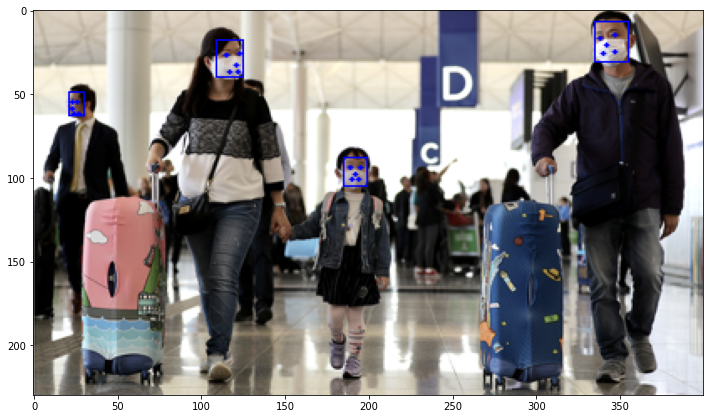

In [6]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def draw_bbox(bounding_boxes, image):
    for i in range(len(bounding_boxes)):
        x1, y1, x2, y2 = bounding_boxes[i]
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1)
    
    return image

def plot_landmarks(landmarks, image):
    for i in range(len(landmarks)):
        for p in range(landmarks[i].shape[0]):
            cv2.circle(image, 
                      (int(landmarks[i][p, 0]), int(landmarks[i][p, 1])), 1, (0, 0, 255), -1, cv2.LINE_AA)
    return image

# Create face detector
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device=device)

# Load a single image from dataset
input_img = cv2.imread(BASE_PATH + 'face-mask-detection/images/maksssksksss320.png')
converted_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

# Detect faces
faces, conf, landmarks = mtcnn.detect(converted_img, landmarks=True)

output_img = draw_bbox(faces, converted_img)
output_img = plot_landmarks(landmarks, output_img)

plt.figure(figsize=(12, 12))
plt.imshow(output_img)

# Figure out the Distance between People in a Photo

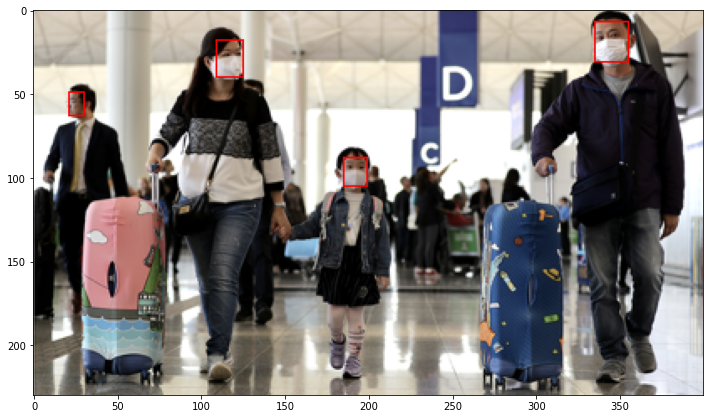

In [7]:
from scipy.spatial import distance

MIN_DISTANCE = 200

if len(faces) < 2:
    print("Number of people who was detected was less than two.")        
else:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces) - 1):
        for j in range(i + 1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    for i in range(len(faces)):
        x1, y1, x2, y2 = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 1)
        else:
            cv2.rectangle(new_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    plt.figure(figsize=(12, 12))
    plt.imshow(new_img)

## Face Mask Detection with ResNet18

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchsummary import summary
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# Set up paths
traindir = BASE_PATH + 'face-mask-12k-images-dataset/Train/'
testdir = BASE_PATH + 'face-mask-12k-images-dataset/Test/'
valdir = BASE_PATH + 'face-mask-12k-images-dataset/Validation/'

In [10]:
# A method to create dataset and argument images
class MaskDataset(Dataset):
    def __init__ (self, path):
        mask_imgs = glob(path + 'WithMask/*.png')
        nomask_imgs = glob(path + 'WithoutMask/*.png')

        self.img_path = mask_imgs + nomask_imgs
        self.target = ['WithMask' in img_path.split('/')[-2] for img_path in self.img_path]

    def __len__(self):
        return len(self.img_path) 
    
    def __getitem__(self, idx):
        img = self.img_path[idx]
        target = self.target[idx] 
        from PIL import Image
        input_img = Image.open(img)
        preprocess = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_img)
        return input_tensor.float().to(device), torch.tensor([target]).float().to(device)

Number of train data: 10000
Number of validation data: 800
Number of test data: 992



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


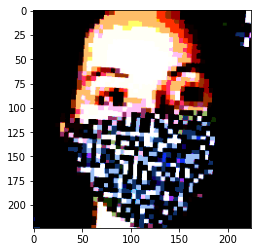

Label: 1.0



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


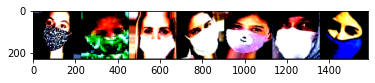

Labels:      1.0,       1.0,       1.0,       1.0,       1.0,       1.0,       1.0



In [11]:
# Construct train data, validation data, test data
train_data = MaskDataset(traindir)
val_data = MaskDataset(valdir)
test_data = MaskDataset(testdir)

print("Number of train data: {}".format(len(train_data)))
print("Number of validation data: {}".format(len(val_data)))
print("Number of test data: {}".format(len(test_data)))
print()

# Check out images in the train dataset and their label
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

img, label = train_data[400]
imshow(img)
print("Label: {}".format(label.item()))
print()

images = []
labels = []
for j in range(1, 8):
  i, l = train_data[j]
  images.append(i)
  labels.append(l)
imshow(torchvision.utils.make_grid(images))
print("Labels:" + ', '.join('%9s' % labels[j].item() for j in range(7)))
print()

Number of elements in the batch 32
Image size (batch, channel, height, width): torch.Size([32, 3, 224, 224])
Number of labels in the batch: torch.Size([32, 1])



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


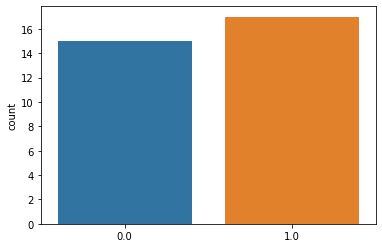

In [12]:
BATCH_SIZE = 32
SHUFFLE = True
NUM_WORKERS = 0

# Define dataloaders for train, validation, test with batch size 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS) 
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS) 
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS) 

# Figure out the stats in one batch
images, labels = iter(train_loader).next() 

print("Number of elements in the batch", len(labels))
print("Image size (batch, channel, height, width):", images.shape)
print("Number of labels in the batch:", labels.shape)
print()

sns.countplot(np.array(labels.cpu())[:,0]);

In [13]:
# Set up constants
EPOCHS = 10
LR = 1e-3
PRINT_EVERY = 10
VERBOSE = 1

In [14]:
def train(net, dataloader, epochs=EPOCHS, lr=LR, print_every=PRINT_EVERY, 
          verbose=VERBOSE):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        sum_loss = 0.0
        losses_epoch = []

        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0], batch[1]

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses_epoch.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every - 1:
                if verbose:
                    print("Train Epoch: %5d, Batch: %5d, Loss: %.3f" % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0

        losses.append(np.array(losses_epoch).mean())
    return losses
    
@torch.no_grad()
def predict(net, dataloader, epochs=EPOCHS, print_every=PRINT_EVERY, verbose=VERBOSE):
    net.eval()
    accuracies = []

    for epoch in range(epochs):
        accuracies_epoch = []

        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0], batch[1]
            prediction = net(inputs)
            is_correct = (prediction > 0.5) == labels
            accuracy = is_correct.cpu().numpy().tolist()
            accuracies_epoch.extend(accuracy)

            if i % print_every == print_every - 1:
                if verbose:
                    print("Predict Epoch: %5d, Batch: %5d" % (epoch, i + 1))

        accuracies.append(np.mean(accuracies_epoch))
    return accuracies


@torch.no_grad()
def validate(net, dataloader, epochs=EPOCHS, print_every=PRINT_EVERY, verbose=VERBOSE):
    net.eval()
    criterion = nn.BCELoss()
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        val_losses_epoch = []
        val_accuracies_epoch = []

        for i, batch in enumerate(dataloader):
            inputs, labels = batch[0], batch[1]
            prediction = net(inputs)
            is_correct = (prediction > 0.5) == labels
            accuracy = is_correct.cpu().numpy().tolist()
            val_accuracies_epoch.extend(accuracy)
            val_losses_epoch.append(criterion(prediction, labels).item())

            if i % print_every == print_every - 1:
                if verbose:
                    print("Vlidate Epoch: %5d, Batch: %5d" % (epoch, i + 1))

        val_accuracies.append(np.mean(val_accuracies_epoch))
        val_losses.append(np.array(val_losses_epoch).mean())
    return val_losses, val_accuracies

In [15]:
def ResNet18():
    model = models.resnet18(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False
    
    model.avgpool = nn.AdaptiveAvgPool2d(1)

    model.fc = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid())

    return model

model_resnet18 = ResNet18()
summary(model_resnet18.to(device), (3,224,224))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64

In [16]:
train_losses = train(model_resnet18, train_loader)
train_accuracies = predict(model_resnet18, train_loader)
val_losses, val_accuracies = validate(model_resnet18, val_loader)

Train Epoch:     0, Batch:    10, Loss: 0.445
Train Epoch:     0, Batch:    20, Loss: 0.177
Train Epoch:     0, Batch:    30, Loss: 0.133
Train Epoch:     0, Batch:    40, Loss: 0.168
Train Epoch:     0, Batch:    50, Loss: 0.081
Train Epoch:     0, Batch:    60, Loss: 0.080
Train Epoch:     0, Batch:    70, Loss: 0.096
Train Epoch:     0, Batch:    80, Loss: 0.100
Train Epoch:     0, Batch:    90, Loss: 0.070
Train Epoch:     0, Batch:   100, Loss: 0.075
Train Epoch:     0, Batch:   110, Loss: 0.072
Train Epoch:     0, Batch:   120, Loss: 0.059
Train Epoch:     0, Batch:   130, Loss: 0.061
Train Epoch:     0, Batch:   140, Loss: 0.065
Train Epoch:     0, Batch:   150, Loss: 0.074
Train Epoch:     0, Batch:   160, Loss: 0.041
Train Epoch:     0, Batch:   170, Loss: 0.022
Train Epoch:     0, Batch:   180, Loss: 0.056
Train Epoch:     0, Batch:   190, Loss: 0.028
Train Epoch:     0, Batch:   200, Loss: 0.107
Train Epoch:     0, Batch:   210, Loss: 0.045
Train Epoch:     0, Batch:   220, 

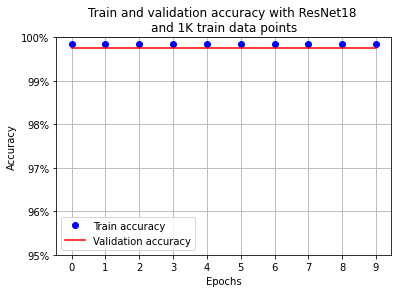

In [19]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

epochs = np.arange(EPOCHS)
plt.plot(epochs, train_accuracies, 'bo', label='Train accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Train and validation accuracy with ResNet18 \nand 1K train data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

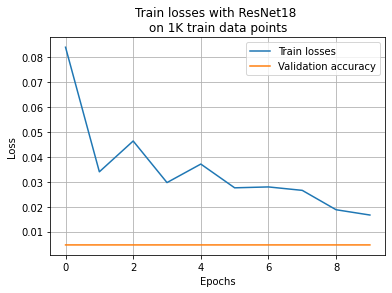

In [21]:
plt.plot(train_losses, label='Train losses')
plt.plot(epochs, val_losses, label='Validation accuracy')
plt.title('Train losses with ResNet18 \non 1K train data points')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [22]:
# Calculate the test accuracy
test_accuracies = []
for epoch in range(5):
    test_epoch_accuracies = []
    for i, batch in enumerate(test_loader):
        inputs, labels = batch[0], batch[1]
        prediction = model_resnet18(inputs)
        is_correct = (prediction > 0.5) == labels
        accuracy = is_correct.cpu().numpy().tolist()
        test_epoch_accuracies.extend(accuracy)
    test_epoch_accuracy = np.mean(test_epoch_accuracies)
    test_accuracies.append(test_epoch_accuracy)

print("An accuarcy of the model: ", max(test_accuracies) * 100, "%")
print()

An accuarcy of the model:  99.49596774193549 %



In [23]:
model_path = BASE_PATH + 'resnet18_model_v2.pth'
torch.save(model_resnet18.state_dict(), model_path)

## Face Mask Detection with ResNet34

In [24]:
def ResNet34():
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False
    
    model.avgpool = nn.AdaptiveAvgPool2d(1)

    model.fc = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid())

    return model

model_resnet34 = ResNet34()
summary(model_resnet34.to(device), (3,224,224))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64

In [25]:
train_losses_34 = train(model_resnet34, train_loader)
train_accuracies_34 = predict(model_resnet34, train_loader)
val_losses_34, val_accuracies_34 = validate(model_resnet34, val_loader)

Train Epoch:     0, Batch:    10, Loss: 0.435
Train Epoch:     0, Batch:    20, Loss: 0.176
Train Epoch:     0, Batch:    30, Loss: 0.116
Train Epoch:     0, Batch:    40, Loss: 0.145
Train Epoch:     0, Batch:    50, Loss: 0.133
Train Epoch:     0, Batch:    60, Loss: 0.155
Train Epoch:     0, Batch:    70, Loss: 0.134
Train Epoch:     0, Batch:    80, Loss: 0.052
Train Epoch:     0, Batch:    90, Loss: 0.088
Train Epoch:     0, Batch:   100, Loss: 0.035
Train Epoch:     0, Batch:   110, Loss: 0.073
Train Epoch:     0, Batch:   120, Loss: 0.028
Train Epoch:     0, Batch:   130, Loss: 0.064
Train Epoch:     0, Batch:   140, Loss: 0.044
Train Epoch:     0, Batch:   150, Loss: 0.120
Train Epoch:     0, Batch:   160, Loss: 0.037
Train Epoch:     0, Batch:   170, Loss: 0.036
Train Epoch:     0, Batch:   180, Loss: 0.029
Train Epoch:     0, Batch:   190, Loss: 0.038
Train Epoch:     0, Batch:   200, Loss: 0.028
Train Epoch:     0, Batch:   210, Loss: 0.030
Train Epoch:     0, Batch:   220, 

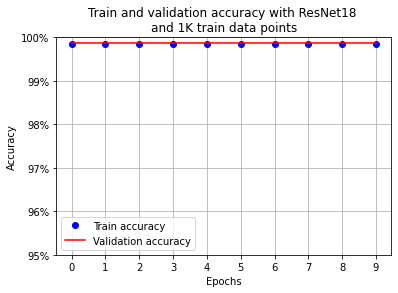

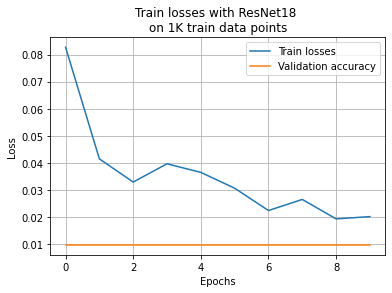

In [26]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

epochs = np.arange(EPOCHS)
plt.plot(epochs, train_accuracies_34, 'bo', label='Train accuracy')
plt.plot(epochs, val_accuracies_34, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Train and validation accuracy with ResNet18 \nand 1K train data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

plt.plot(train_losses_34, label='Train losses')
plt.plot(epochs, val_losses_34, label='Validation accuracy')
plt.title('Train losses with ResNet18 \non 1K train data points')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [28]:
# Calculate the test accuracy
test_accuracies_34 = []
for epoch in range(5):
    test_epoch_accuracies_34 = []
    for i, batch in enumerate(test_loader):
        inputs, labels = batch[0], batch[1]
        prediction = model_resnet34(inputs)
        is_correct = (prediction > 0.5) == labels
        accuracy = is_correct.cpu().numpy().tolist()
        test_epoch_accuracies_34.extend(accuracy)
    test_epoch_accuracy_34 = np.mean(test_epoch_accuracies_34)
    test_accuracies_34.append(test_epoch_accuracy_34)

print("An accuarcy of the model: ", max(test_accuracies_34) * 100, "%")
print()

An accuarcy of the model:  99.8991935483871 %



In [29]:
model_path_34 = BASE_PATH + 'resnet34_model_v0.pth'
torch.save(model_resnet34.state_dict(), model_path_34)

## Annotate based on the output from the model with ResNet34

tensor([[0.9898]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.9644]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.7766]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.6077]], device='cuda:0', grad_fn=<SigmoidBackward>)


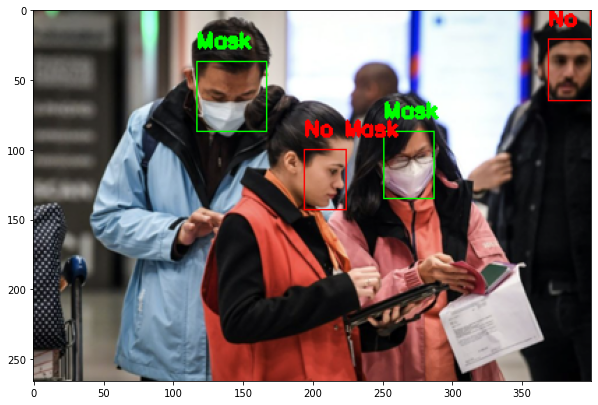

In [61]:
mask_label = {0:'Mask', 1:'No Mask'}
mask_on_label = {0: (0, 255, 0), 1: (255, 0, 0)}
dist_label = {0: (0, 255, 0), 1: (255 ,0 , 0)}

test_img = cv2.imread(BASE_PATH + 'face-mask-detection/images/maksssksksss5.png')
faces, conf, landmarks = mtcnn.detect(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB), landmarks=True)

if len(faces) >=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces) - 1):
        for j in range(i + 1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        crop = new_img[int(y) : int(h), int(x) : int(w)]
        crop = cv2.resize(crop,(224, 224))
        crop = torch.tensor(crop/255)
        crop = crop.permute(2, 0, 1)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        crop = normalize(crop)
        crop = crop.float().to(device)
        crop = crop.unsqueeze(0)
        eval_model = ResNet34().to(device)
        eval_model.load_state_dict(torch.load(model_path_34))
        eval_model.eval()
        pred = eval_model(crop)
        mask_result = 1
        print(pred)
        if pred > 0.8:
          mask_result = 0
        cv2.putText(new_img, mask_label[mask_result], (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, mask_on_label[mask_result], 2)
        d = label[i]
        if mask_result == 0:
          d = 0
        cv2.rectangle(new_img, (int(x), int(y)), (int(w), int(h)), dist_label[d], 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(new_img)
            
else:
    print("No faces are detected.")

## Detect Nose and Mouth to find Peple Wearing a Mask Improperly